In [95]:
!pip install factor_analyzer
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.decomposition import PCA, SparsePCA
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [96]:
DATA_PATH  = '/content/drive/MyDrive/DFI_data 1.18-2.25.csv'
OUTPUT_DIR = '/content/drive/MyDrive/Results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

ACCESS_VARS = ['A1','A2','A3','A4','A5','A6','A7','A8','A9']
USAGE_VARS  = ['U1','U2','U3','U4','U5','U6','U7','U8','U9','U10']
ALL_VARS    = ACCESS_VARS + USAGE_VARS

In [97]:
# 1. Load Data

df_raw = pd.read_csv(DATA_PATH)

new_cols = ["Date"] + ACCESS_VARS + USAGE_VARS
df_raw.columns = new_cols   #renaming the columns


print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head()

Shape: (86, 20)
Columns: ['Date', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'U1', 'U2', 'U3', 'U4', 'U5', 'U6', 'U7', 'U8', 'U9', 'U10']


,Date,A1,A2,A3,A4,A5,A6,A7,A8,A9,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
0,Feb-2025,NaN,1.416353e+09,NaN,216836.0,10717514.0,653.0,985676745.0,109315356.0,1.361438e+09,190952.14,6398.44,244.20,4048.29,1533.06,7647.93,161061.93,3969.59,1082.50,150031.46
1,Jan-2025,NaN,1.413167e+09,NaN,216706.0,10352730.0,647.0,982039277.0,108873184.0,1.346321e+09,200754.53,6547.10,268.15,4442.23,1304.72,8567.93,169960.01,4305.72,1216.69,158794.78
2,Dec-2024,1.150660e+09,1.411647e+09,944960000.0,214398.0,10000549.0,641.0,990948054.0,108055905.0,1.328565e+09,197940.75,6377.99,262.29,4411.64,1315.94,8307.02,167300.09,4328.50,1280.10,156762.66
3,Nov-2024,1.148650e+09,1.409873e+09,944760000.0,215387.0,9690872.0,637.0,979571767.0,107239710.0,1.562408e+09,183512.36,5847.81,240.29,4079.18,1438.33,7769.51,154820.21,3936.04,1234.98,144939.48
4,Oct-2024,1.150420e+09,1.409531e+09,941470000.0,216208.0,9509265.0,632.0,980910678.0,106889655.0,1.550327e+09,199078.71,5977.88,267.92,4668.23,1463.68,9183.38,165849.66,4332.14,1441.87,156523.15


In [98]:
# 2. Parse date and set index

date_col = df_raw.columns[0]  # change if needed
df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce")
df_raw = df_raw.set_index(date_col)
df_raw.index.name = "Date"

df_raw.head()

/tmp/ipython-input-4089978381.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce")


,A1,A2,A3,A4,A5,A6,A7,A8,A9,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
Date,,,,,,,,,,,,,,,,,,,
2025-02-01,NaN,1.416353e+09,NaN,216836.0,10717514.0,653.0,985676745.0,109315356.0,1.361438e+09,190952.14,6398.44,244.20,4048.29,1533.06,7647.93,161061.93,3969.59,1082.50,150031.46
2025-01-01,NaN,1.413167e+09,NaN,216706.0,10352730.0,647.0,982039277.0,108873184.0,1.346321e+09,200754.53,6547.10,268.15,4442.23,1304.72,8567.93,169960.01,4305.72,1216.69,158794.78
2024-12-01,1.150660e+09,1.411647e+09,944960000.0,214398.0,10000549.0,641.0,990948054.0,108055905.0,1.328565e+09,197940.75,6377.99,262.29,4411.64,1315.94,8307.02,167300.09,4328.50,1280.10,156762.66
2024-11-01,1.148650e+09,1.409873e+09,944760000.0,215387.0,9690872.0,637.0,979571767.0,107239710.0,1.562408e+09,183512.36,5847.81,240.29,4079.18,1438.33,7769.51,154820.21,3936.04,1234.98,144939.48
2024-10-01,1.150420e+09,1.409531e+09,941470000.0,216208.0,9509265.0,632.0,980910678.0,106889655.0,1.550327e+09,199078.71,5977.88,267.92,4668.23,1463.68,9183.38,165849.66,4332.14,1441.87,156523.15


Missing values per series:



,0
A1,2
A2,0
A3,2
A4,0
A5,0
A6,0
A7,23
A8,22
A9,22
U1,22


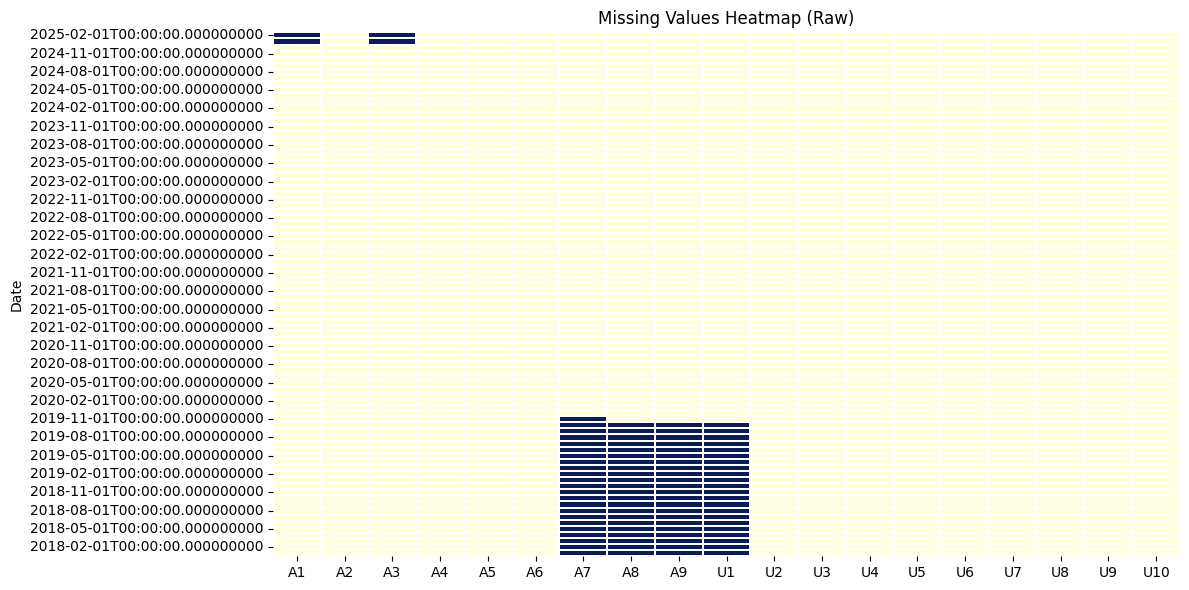

In [99]:
# 3. Missing Values Overview

missing_counts = df_raw[ALL_VARS].isnull().sum()
print("Missing values per series:\n")
display(missing_counts)

# Heatmap of missingness (raw)
mask_raw = df_raw[ALL_VARS].isnull()
plt.figure(figsize=(12, 6))
sns.heatmap(mask_raw, cbar=False, cmap="YlGnBu", linewidths=0.3)
plt.title("Missing Values Heatmap (Raw)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "missing_heatmap_raw.png"), dpi=300)
plt.show()

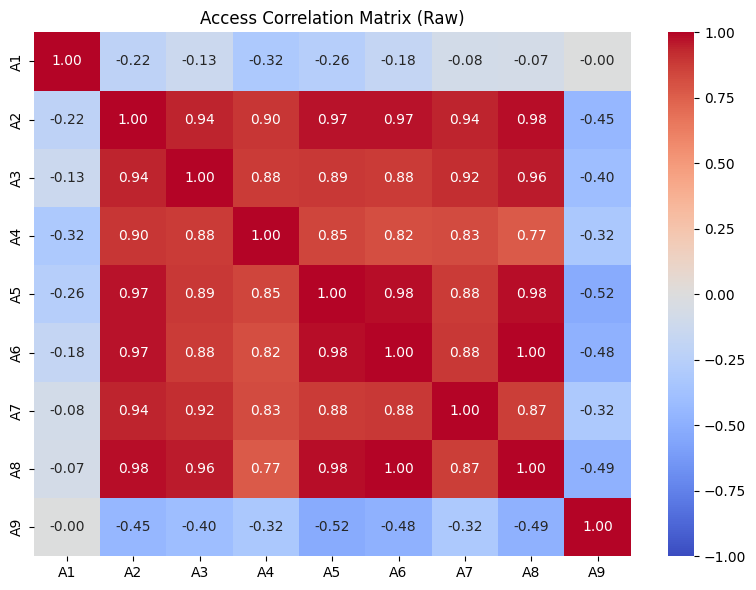

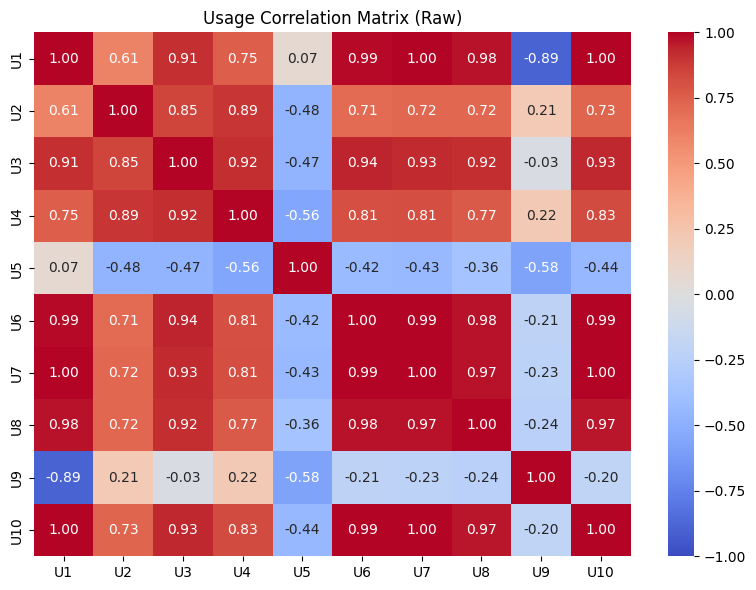

In [100]:
# Correlation matrices (raw, before imputation)
for label, vars_ in [("access", ACCESS_VARS), ("usage", USAGE_VARS)]:
    corr_raw = df_raw[vars_].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_raw, annot=True, cmap="coolwarm", fmt='.2f', vmin=-1, vmax=1)
    plt.title(f"{label.capitalize()} Correlation Matrix (Raw)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{label}_corr_raw.png"), dpi=300)
    plt.show()

In [101]:
## 4. Missing Values Imputation using Seasonal Structural Time Series Model

df_raw = df_raw.asfreq('MS')

df_impute = df_raw.copy()
corr_full = df_raw.corr().abs()
missing_vars = ['A7','A8','A9','U1']

for var in missing_vars:
    candidates = corr_full[var].sort_values(ascending=False).index.drop(var)
    peers = [p for p in candidates if df_raw[p].notna().all()][:2]

    if len(peers) < 2:
        peers = list(candidates[:2])

    model = UnobservedComponents(
        endog=df_raw[var],
        level='local level',
        seasonal=12,
        exog=df_raw[peers]
    )

    res = model.fit(method='powell', maxiter=1000, disp=False)
    df_impute[var] = df_raw[var].fillna(res.predict())

df_impute.to_excel(os.path.join(OUTPUT_DIR, 'DFI_imputed.xlsx'))
print("Imputed data saved to 'DFI_imputed.xlsx'.")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Imputed data saved to 'DFI_imputed.xlsx'.


Missing values per series:



,0
A1,2
A2,0
A3,2
A4,0
A5,0
A6,0
A7,0
A8,0
A9,0
U1,0


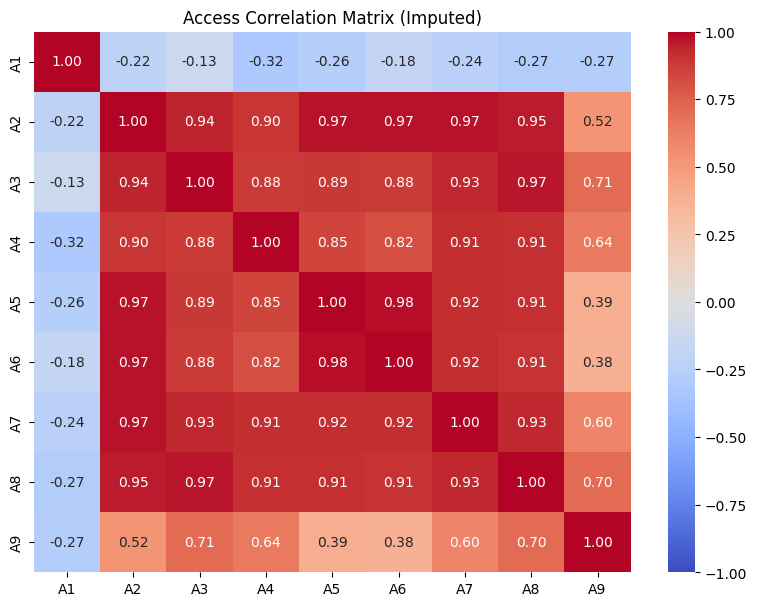

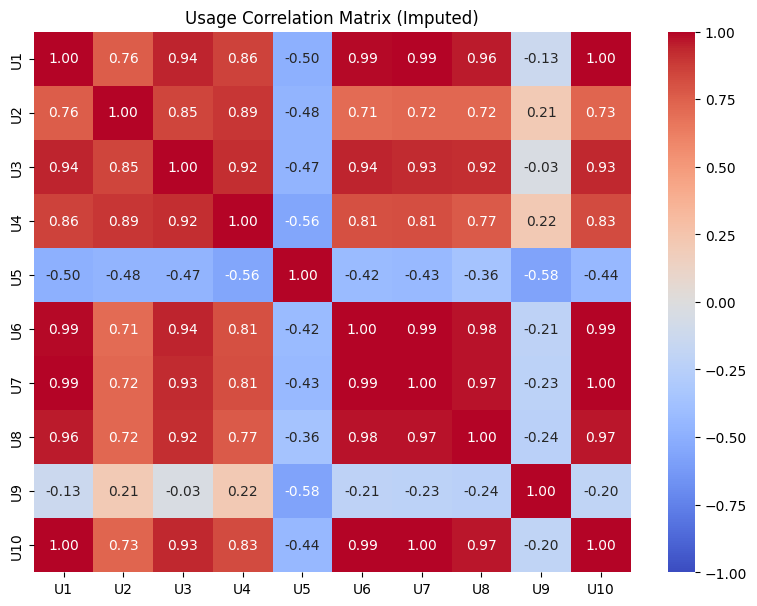

In [102]:
## 5. Post Imputation Diagnostics

# Missingness
missing_counts = df_impute[ALL_VARS].isnull().sum()
print("Missing values per series:\n")
display(missing_counts)

# Correlation

for label, vars_ in [("access", ACCESS_VARS), ("usage", USAGE_VARS)]:
    corr_raw = df_impute[vars_].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_raw, annot=True, cmap="coolwarm", fmt='.2f', vmin=-1, vmax=1)
    plt.tight_layout()
    plt.title(f"{label.capitalize()} Correlation Matrix (Imputed)")
    plt.savefig(os.path.join(OUTPUT_DIR, f"{label}_corr_raw.png"), dpi=300)
    plt.show()

In [103]:
## Stationarity, Differencing and Normalisation

results = []
stationary_series = {}
adf_crit_5 = None
max_diff = 2

for col in ALL_VARS:
    series = df_impute[col].copy()
    order = 0

    while True:
        s_clean = series.dropna()

        adf_res = adfuller(s_clean, autolag="AIC")
        adf_stat = adf_res[0]
        pvalue  = adf_res[1]
        crit_vals = adf_res[4]

        if adf_crit_5 is None:
            adf_crit_5 = crit_vals["5%"]

        # stop if stationary or already differenced twice
        if (pvalue < 0.05) or (order >= max_diff):
            break

        # otherwise difference again and try once more
        series = series.diff()
        order += 1

    # save final stationary series
    stationary_series[col] = series

    diff_label = "No Differencing" if order == 0 else str(order)

    results.append(
        {
            "Indicator": col,
            "Differencing Level": diff_label,
            "ADF Statistic": adf_stat,
        }
    )

# build stationary dataframe
df_stationary = pd.DataFrame(stationary_series, index=df_impute.index)
df_stationary = df_stationary.dropna(how="any")

# z-score normalization
scaler = StandardScaler()
df_stationary_norm = pd.DataFrame(
    scaler.fit_transform(df_stationary),
    index=df_stationary.index,
    columns=df_stationary.columns,
)

# final ADF summary table
adf_table = pd.DataFrame(results)[
    ["Indicator", "Differencing Level", "ADF Statistic"]
]

display(adf_table)

adf_table.to_excel(
    os.path.join(OUTPUT_DIR, "ADF_stationarity_results.xlsx"),
    index=False,
)

print(f"\nADF value @ 5% Critical Value = {adf_crit_5:.9f}")

,Indicator,Differencing Level,ADF Statistic
0,A1,No Differencing,-3.057049
1,A2,1,-8.528838
2,A3,2,-3.855599
3,A4,1,-9.946530
4,A5,1,-12.806494
5,A6,2,-6.447908
6,A7,1,-9.872582
7,A8,1,-9.169280
8,A9,1,-8.216296
9,U1,2,-5.899694



ADF value @ 5% Critical Value = -2.897489865


In [104]:
## 7. KMO & Bartlett

data_stat = df_stationary_norm[ALL_VARS].copy()

kmo_items, kmo_overall = calculate_kmo(data_stat)
chi2, p = calculate_bartlett_sphericity(data_stat)

n_vars = data_stat.shape[1]
df_bartlett = n_vars * (n_vars - 1) // 2 # degrees of freedom

star = "*" if p < 0.05 else ""

kmo_bartlett_table = pd.DataFrame({"Measure": ["KMO (Kaiser–Meyer–Olkin)","Bartlett’s test of sphericity"],
                                   "Result": [f"{kmo_overall:.5f}",f"{chi2:.2f}{star} ({df_bartlett})"],})

display(kmo_bartlett_table)

print("KMO per item (post-stationarity):\n")
display(pd.Series(kmo_items, index=data_stat.columns))

,Measure,Result
0,KMO (Kaiser–Meyer–Olkin),0.75243
1,Bartlett’s test of sphericity,1165.19* (171)


KMO per item (post-stationarity):



,0
A1,0.118182
A2,0.417228
A3,0.598567
A4,0.544615
A5,0.559447
A6,0.150977
A7,0.423759
A8,0.512248
A9,0.668834
U1,0.822369


In [105]:
## 8. Stage 1 PCA - Access & Usage

df_clean = df_impute[ALL_VARS].dropna(how="any")

X_access = df_clean[ACCESS_VARS].copy()
X_usage  = df_clean[USAGE_VARS].copy()


# 8.1 Standardise each block (mean 0, var 1)
scaler_a = StandardScaler()
df_access_std = pd.DataFrame(
    scaler_a.fit_transform(X_access),
    index=X_access.index,
    columns=ACCESS_VARS
)

scaler_u = StandardScaler()
df_usage_std = pd.DataFrame(
    scaler_u.fit_transform(X_usage),
    index=X_usage.index,
    columns=USAGE_VARS
)

# 8.2 PCA for Access
pca_a = PCA().fit(df_access_std)
eigvals_a   = pca_a.explained_variance_
var_ratio_a = pca_a.explained_variance_ratio_
cum_var_a   = var_ratio_a.cumsum()
eigvecs_a   = pca_a.components_.T
loadings_a = eigvecs_a

# raw weights per PC
raw_w_a  = loadings_a.sum(axis=0)
norm_w_a = raw_w_a / raw_w_a.sum()

pcs_access = [f"PC{i+1}" for i in range(len(eigvals_a))]

rows_access = {}
rows_access["Eigenvalues"] = np.round(eigvals_a, 2)

for idx, var in enumerate(ACCESS_VARS):
    rows_access[var] = np.round(loadings_a[idx, :], 4)

rows_access["Normalised Weights"]  = np.round(norm_w_a, 4)
rows_access["Variance Explained"]  = (var_ratio_a * 100).round(2).astype(str) + "%"
rows_access["Cumulative Variance"] = (cum_var_a * 100).round(2).astype(str) + "%"

df_access_table = pd.DataFrame(rows_access, index=pcs_access).T

print("\nACCESS – PCA table:")
display(df_access_table)


# 8.3 PCA for Usage
pca_u = PCA().fit(df_usage_std)
eigvals_u   = pca_u.explained_variance_
var_ratio_u = pca_u.explained_variance_ratio_
cum_var_u   = var_ratio_u.cumsum()
eigvecs_u   = pca_u.components_.T
loadings_u = eigvecs_u

raw_w_u    = loadings_u.sum(axis=0)
norm_w_u   = raw_w_u / raw_w_u.sum()

pcs_usage = [f"PC{i+1}" for i in range(len(eigvals_u))]

rows_usage = {}
rows_usage["Eigenvalues"] = np.round(eigvals_u, 2)

for idx, var in enumerate(USAGE_VARS):
    rows_usage[var] = np.round(loadings_u[idx, :], 4)

rows_usage["Normalised Weights"]  = np.round(norm_w_u, 4)
rows_usage["Variance Explained"]  = (var_ratio_u * 100).round(2).astype(str) + "%"
rows_usage["Cumulative Variance"] = (cum_var_u * 100).round(2).astype(str) + "%"

df_usage_table = pd.DataFrame(rows_usage, index=pcs_usage).T

print("\nUSAGE – PCA table:")
display(df_usage_table)


# 4) Sub-indices A_t and U_t (using retained PCs with eigenvalue > 1)

mask_a = eigvals_a > 1
mask_u = eigvals_u > 1

print("\nNumber of retained PCs (Access):", mask_a.sum())
print("Number of retained PCs (Usage):",  mask_u.sum())

scores_a = pca_a.transform(df_access_std)
scores_u = pca_u.transform(df_usage_std)


# 5) Save tables + subindices
with pd.ExcelWriter(os.path.join(OUTPUT_DIR, "Stage1_PCA_tables.xlsx")) as writer:
    df_access_table.to_excel(writer, sheet_name="ACCESS_Table")
    df_usage_table.to_excel(writer, sheet_name="USAGE_Table")
    pd.concat([A_t, U_t], axis=1).to_excel(writer, sheet_name="Subindices")

print("\nStage 1 PCA tables and sub-indices saved to 'Stage1_PCA_tables.xlsx'.")
pd.concat([A_t, U_t], axis=1).head()


ACCESS – PCA table:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Eigenvalues,7.08,1.01,0.74,0.14,0.06,0.04,0.02,0.01,0.0
A1,-0.1093,0.891,0.4013,0.1063,-0.034,-0.1064,0.0533,0.0764,0.0263
A2,0.3721,0.1195,-0.1268,-0.0549,0.1334,-0.0295,-0.0691,-0.338,0.831
A3,0.3646,0.1064,0.1947,-0.2053,-0.0954,0.7868,-0.0327,-0.2962,-0.2423
A4,0.3554,-0.0782,0.0295,0.8608,-0.3192,-0.0459,0.015,-0.1196,-0.0843
A5,0.3583,0.1203,-0.3141,-0.1435,-0.1609,0.018,0.7502,0.3856,0.0105
A6,0.3536,0.2023,-0.289,-0.2702,-0.0611,-0.5077,-0.1419,-0.4411,-0.4488
A7,0.3682,0.0569,-0.0261,0.1879,0.8236,0.0299,-0.1385,0.3055,-0.183
A8,0.3718,-0.0225,0.1104,-0.212,-0.3961,-0.0783,-0.5487,0.5762,0.0891
A9,0.2512,-0.3395,0.7675,-0.1692,0.0724,-0.3186,0.2963,-0.0968,0.0046



USAGE – PCA table:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Eigenvalues,7.59,1.72,0.5,0.14,0.09,0.05,0.02,0.01,0.0,0.0
U1,0.3607,-0.064,-0.1341,0.1085,0.0421,-0.3168,-0.2342,-0.2553,-0.4314,-0.654
U2,0.3033,0.2017,0.6123,-0.5547,-0.3433,-0.1655,-0.1778,0.0881,0.0116,0.0097
U3,0.3553,0.0041,0.1693,0.0552,0.2308,0.7996,-0.2929,-0.2518,0.0132,-0.008
U4,0.337,0.1791,0.3121,0.093,0.6295,-0.1625,0.5573,0.1202,-0.0219,0.0069
U5,-0.1944,-0.5343,0.6316,0.4961,-0.0489,-0.118,-0.1203,-0.0297,-0.0025,0.0081
U6,0.3547,-0.1414,-0.1539,0.191,-0.0595,0.0711,-0.2154,0.8509,-0.1106,0.0523
U7,0.3558,-0.1419,-0.1507,0.0519,0.0068,-0.2641,-0.1334,-0.3071,-0.302,0.7448
U8,0.3469,-0.1683,-0.0549,0.1608,-0.6078,0.2135,0.6231,-0.1165,0.0008,-0.075
U9,-0.0001,0.744,0.1048,0.5911,-0.2318,-0.0649,-0.145,-0.0384,0.0264,0.0698



Number of retained PCs (Access): 2
Number of retained PCs (Usage): 2

Stage 1 PCA tables and sub-indices saved to 'Stage1_PCA_tables.xlsx'.


,A_t,U_t
Date,,
2018-01-01,-3.280797,-3.438992
2018-02-01,-3.125492,-3.564670
2018-03-01,-2.686577,-3.409062
2018-04-01,-3.445845,-3.658212
2018-05-01,-3.221128,-3.405250


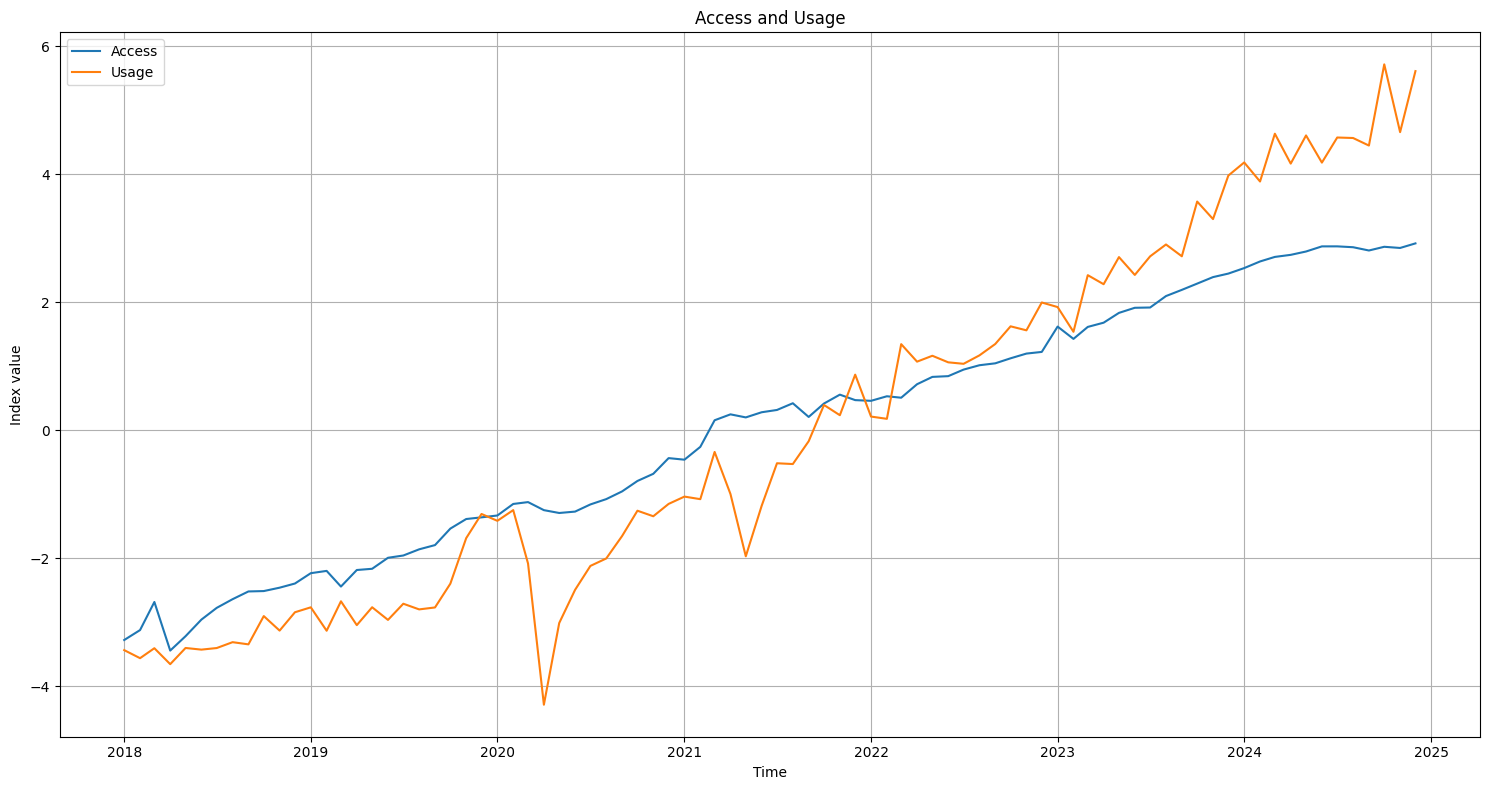

In [106]:
## 9. Plot: Access vs. Usage

plt.figure(figsize=(15, 8))

plt.plot(df_indices.index, df_indices["A_t"], label="Access")
plt.plot(df_indices.index, df_indices["U_t"], label="Usage")

plt.title("Access and Usage")
plt.xlabel("Time")
plt.ylabel("Index value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Access_Usage_Index.png"), dpi=300)
plt.show()


In [107]:
## 10. Stage 2 PCA – Composite DFI Index


# Combine Access and Usage sub-indices
df_stage2 = pd.concat([A_t, U_t], axis=1).dropna()
df_stage2.columns = ["A_t", "U_t"]

print("Stage 2 input shape:", df_stage2.shape)
print(df_stage2.head())

# using eigendecomposition
C_S = df_stage2.cov()          # 2x2 covariance matrix
eigvals_S, eigvecs_S = np.linalg.eigh(C_S)

# Sort eigenvalues (and eigenvectors) in descending order
idx = eigvals_S.argsort()[::-1]
eigvals_S = eigvals_S[idx]
eigvecs_S = eigvecs_S[:, idx]

pcs_S = [f"PC{i+1}" for i in range(len(eigvals_S))]

# Explained variance
expl_S = eigvals_S / eigvals_S.sum()
cum_expl_S = expl_S.cumsum()

# 10.1 Table Visualisation
rows_S = {}

rows_S["Eigenvalues"] = np.round(eigvals_S, 6)

rows_S["A_t"] = np.round(eigvecs_S[0, :], 6)
rows_S["U_t"] = np.round(eigvecs_S[1, :], 6) #loadings

v1 = eigvecs_S[:, 0]  #normalised weight
w_raw_sum = v1.sum()
if w_raw_sum == 0:
    w_norm = np.array([0.5, 0.5])
else:
    w_norm = v1 / w_raw_sum

rows_S["Normalised Weights"] = np.round(w_norm, 4)

rows_S["Variance Explained"]  = (expl_S * 100).round(2).astype(str) + "%"
rows_S["Cumulative Variance"] = (cum_expl_S * 100).round(2).astype(str) + "%"


df_stage2_table = pd.DataFrame(rows_S, index=pcs_S).T

print("\nStage 2 PCA – table:")
display(df_stage2_table)

# 10.2 Constructing Composite DFI index from PC1
DFI_t = df_stage2.dot(v1)
DFI_t.name = "DFI"

df_indices = pd.concat([df_stage2, DFI_t], axis=1)

print("\nFirst few values of A_t, U_t and DFI:")
display(df_indices.head())

with pd.ExcelWriter(os.path.join(OUTPUT_DIR, "Stage2_PCA_DFI.xlsx")) as writer:
    df_stage2_table.to_excel(writer, sheet_name="Stage2_Table")
    df_indices.to_excel(writer, sheet_name="Indices")

print("\nStage 2 PCA results saved to 'Stage2_PCA_DFI.xlsx'.")


Stage 2 input shape: (84, 2)
                 A_t       U_t
Date                          
2018-01-01 -3.280797 -3.438992
2018-02-01 -3.125492 -3.564670
2018-03-01 -2.686577 -3.409062
2018-04-01 -3.445845 -3.658212
2018-05-01 -3.221128 -3.405250

Stage 2 PCA – table:


,PC1,PC2
Eigenvalues,11.437577,0.162477
A_t,0.562281,-0.826946
U_t,0.826946,0.562281
Normalised Weights,0.4047,0.5953
Variance Explained,98.6%,1.4%
Cumulative Variance,98.6%,100.0%



First few values of A_t, U_t and DFI:


,A_t,U_t,DFI
Date,,,
2018-01-01,-3.280797,-3.438992,-4.688591
2018-02-01,-3.125492,-3.564670,-4.705196
2018-03-01,-2.686577,-3.409062,-4.329722
2018-04-01,-3.445845,-3.658212,-4.962678
2018-05-01,-3.221128,-3.405250,-4.627138



Stage 2 PCA results saved to 'Stage2_PCA_DFI.xlsx'.


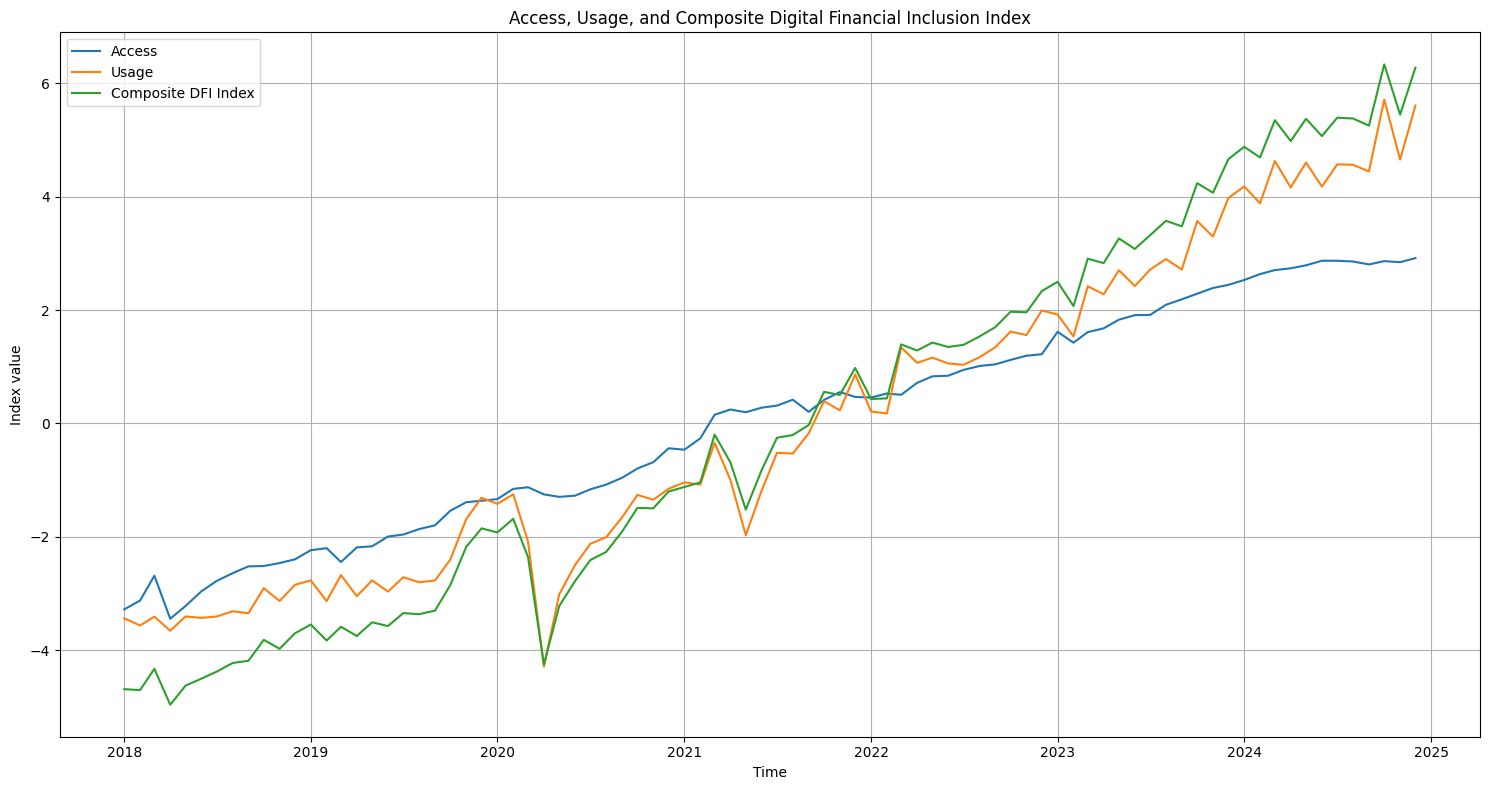

In [108]:
# Plot: Access, Usage, and Composite DFI

plt.figure(figsize=(15, 8))

plt.plot(df_indices.index, df_indices["A_t"],  label="Access")
plt.plot(df_indices.index, df_indices["U_t"],  label="Usage")
plt.plot(df_indices.index, df_indices["DFI"], label="Composite DFI Index")

plt.title("Access, Usage, and Composite Digital Financial Inclusion Index")
plt.xlabel("Time")
plt.ylabel("Index value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Access_Usage_DFI_Index.png"), dpi=300)
plt.show()
